In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from astroML import datasets

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

Using TensorFlow backend.


In [3]:
bands = list('ugriz')

In [4]:
def get_stars_data(scale=True):
    raw_quasars = datasets.fetch_dr7_quasar()
    raw_standards = datasets.fetch_sdss_S82standards()

    standards = pd.DataFrame({band: raw_standards['mmu_' + band] for band in bands})
    standards['ra'] = raw_standards['RA']
    standards['dec'] = raw_standards['DEC']
    standards['is_quasar'] = np.zeros(len(standards))

    quasars = pd.DataFrame({band: raw_quasars['mag_' + band] for band in bands})
    quasars['ra'] = raw_quasars['RA']
    quasars['dec'] = raw_quasars['dec']
    quasars['is_quasar'] = np.ones(len(quasars))

    stars = pd.concat([standards, quasars])
    
    # outliers
    stars = stars[(stars.g - stars.r) > -15]
    
    return stars

In [5]:
stars = get_stars_data()
stars.shape

(1112630, 8)

In [6]:
stars.sample(10)

,g,i,r,u,z,ra,dec,is_quasar
311796,18.955000,16.954000,17.573999,21.615999,16.617001,321.226654,0.932708,0.0
401881,19.070000,18.070000,18.354000,20.740999,17.908001,327.291504,-0.434132,0.0
192139,22.150999,18.761999,20.479000,0.066000,17.863001,315.022400,-0.885458,0.0
63558,20.174999,19.915001,19.913000,20.250000,19.850000,194.267274,61.573606,1.0
865072,21.600000,18.863001,20.153999,-0.323000,18.194000,36.925507,0.107586,0.0
880637,16.695999,15.361000,16.211000,17.040001,14.822000,38.813091,-0.126969,0.0
854748,18.209999,15.617000,16.898001,20.572001,14.946000,34.702900,0.897293,0.0
175103,21.039000,20.284000,20.506001,21.980000,20.215000,314.276062,0.647581,0.0
243763,15.633000,14.936000,15.117000,17.007999,14.884000,317.284485,-0.437247,0.0
5087,19.395000,18.966000,18.952999,19.482000,19.025999,30.206130,13.474692,1.0


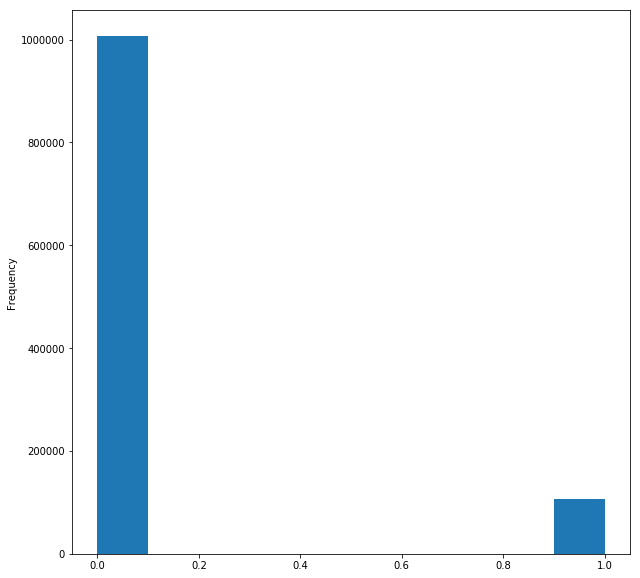

In [7]:
stars.is_quasar.plot.hist()

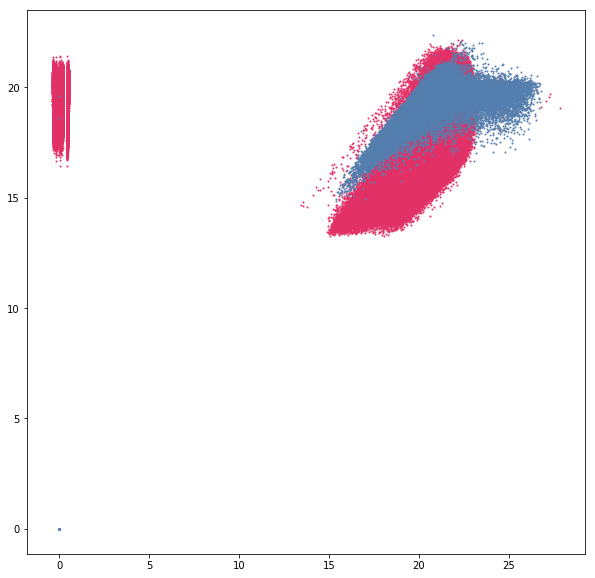

In [8]:
quasars = stars[stars.is_quasar == 1]
others = stars[stars.is_quasar == 0]

plt.scatter(x=others.u, y=others.i, c='#e23167', s=1)
plt.scatter(x=quasars.u, y=quasars.i, c='#547ead', s=1)
plt.show()

#plt.scatter(x=quasars.ra, y=quasars.dec, c='#547ead', s=1)
#plt.scatter(x=others.ra, y=others.dec, c='#e23167', s=1)
#plt.show()

del quasars
del others

In [9]:
input_columns = bands

x = stars[input_columns].values
y = stars.is_quasar.values

scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [10]:
m = Sequential([
    Dense(250, input_shape=(len(input_columns), )),
    Activation('tanh'),
    
    Dropout(0.1),
    
    Dense(250),
    Activation('tanh'),
    
    Dropout(0.1),
    
    Dense(1),
    Activation('sigmoid'),
])

m.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', ],
)

In [11]:
m.fit(
    x_train,
    y_train,
    batch_size=1024,
    epochs=5,
    verbose=2,
)

Epoch 1/5
11s - loss: 0.1354 - acc: 0.9545
Epoch 2/5
3s - loss: 0.0865 - acc: 0.9712
Epoch 3/5
3s - loss: 0.0539 - acc: 0.9835
Epoch 4/5
3s - loss: 0.0316 - acc: 0.9908
Epoch 5/5
3s - loss: 0.0225 - acc: 0.9935


In [12]:
sets = (
    ('train', x_train, y_train),
    ('test', x_test, y_test),
)

for set_name, x_set, y_set in sets:
    y_predicted = np.rint(m.predict(x_set, batch_size=1024))

    print('#' * 25, set_name, '#' * 25)
    print()
    print('Accuracy:', accuracy_score(y_set, y_predicted))
    print()
    print(classification_report(y_set, y_predicted))
    print()

######################### train #########################

Accuracy: 0.995071362448

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    805479
        1.0       0.99      0.96      0.97     84625

avg / total       1.00      1.00      1.00    890104


######################### test #########################

Accuracy: 0.995052263556

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    201370
        1.0       0.99      0.96      0.97     21156

avg / total       1.00      1.00      1.00    222526


